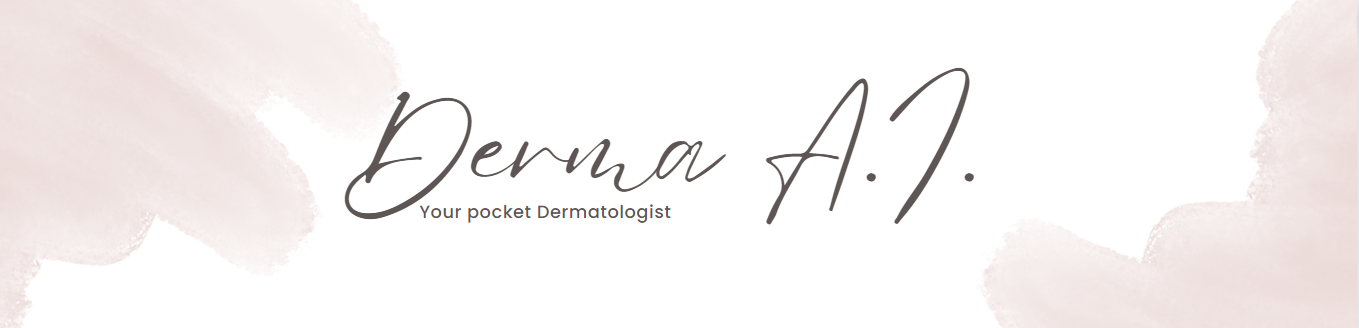

# Derma A.I. : Skin Lesion Screening from your Cameras

### !!WARNING: SKIN IMAGES ARE GRAPHIC!!
Now with this warning out of the way, Let's get to it!

**Ever** woke up one day with a random blemish on your skin? You notice it, get annoyed and move on with your life. It happens.

Fast forward 3 weeks later and it's still there. Now you're worried.

You're contemplating on whether to keep ignoring it and hope it disappears in a few more days or should you go get it professionally checked at a dermatologist. 

In a perfect world, we wouldn't even be contemplating about it. The first time you notice it, you should ideally get it checked out ASAP. But we're not in a perfect world and consultations with a dermatologist or doctor would mean deciding between surviving on cup noodles for a week instead of having three square meals a day. 

We've all been there. And the hope here is that with every day that passes by, newer and newer technologies would bring health realated diagnosis and screening closer to peoples homes and be more accessible both physically and financially. 

And in your pocket lies the secret. *Smartphones*.

With the advent of smartphones, we now have with us microphones, cameras, gyrometers, GPS, blood pressure monitor, and various other more sensors in our pocket. 

What started as a novelty could now prove to be more than just fun and games. These sensors used in the modern smartphones have become so advanced that we can see the craters of the moon. 

These smartphones have so much untapped potential. It only needs the push in the right direction to start making full use of it like developling applications that make full use of this sensor suite found in the smartphone.[1] 

Now come along with me in this project as we explore how to make that into a possibility using the power of deep learning and artificial intelligence!

## Skin Lesions

So to start, what are skin lesions? 

By definition, it is any part of skin that looks different from the surrounding areas.[2][3] This could be due to color differences, phyiscal disfiguraiton like bumps or nodules.

In this project, we take a look at 7 different kinds of skin lesions. 

*(you can expand the bullet points to see sample images)*

####

- **Actinic Keratoses and Intraepithelial Carcinoma / Bowen's disease** (akiec) -
  These are precancerous skin conditions characterized by rough, scaly patches or sores caused by long-term sun exposure or   aging,  with Bowen's disease being a form of squamous cell carcinoma in its earliest


<center> image of akiec </center>

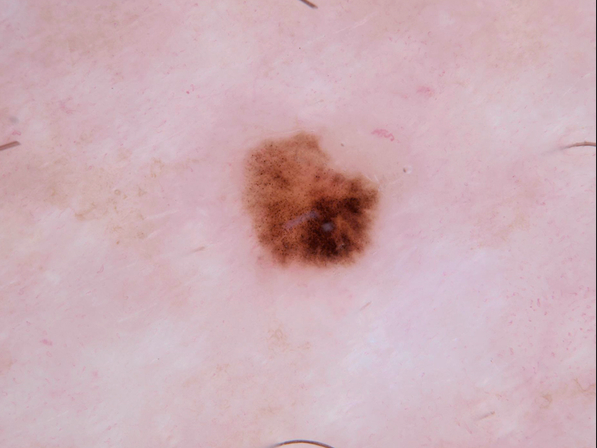

####

- **Basal Cell Carcinoma** (bcc) - These are the most common type of skin cancer, forming in the skin's basal cells. often appears as a shiny bump or nodule that's pearly or translucent

<center> Image of bcc </center>

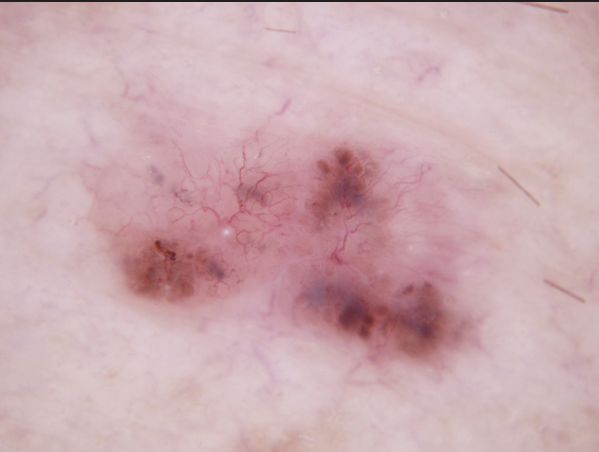

####

- **Benign Keratosis-like lesions** (bkl) - These are non-cancerous growths or spots often related to aging or sun exposure. Presents as small, darkened patches of skin that are usually brown and can vary in size, often appearing on areas of the skin that are most frequently exposed to the sun.

<center> Image of bkl </center>

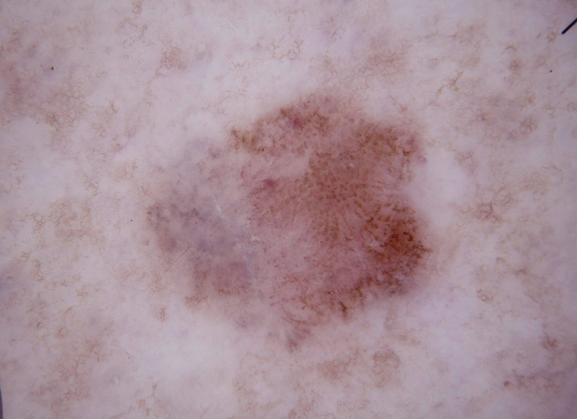

####

- **Dermatofibroma** (df) - There are benign skin bumps composed of fibrous tissue. They are usually small (less than half an inch) and may be pink, red, brown, or purplish.

<center> Image of df </center>

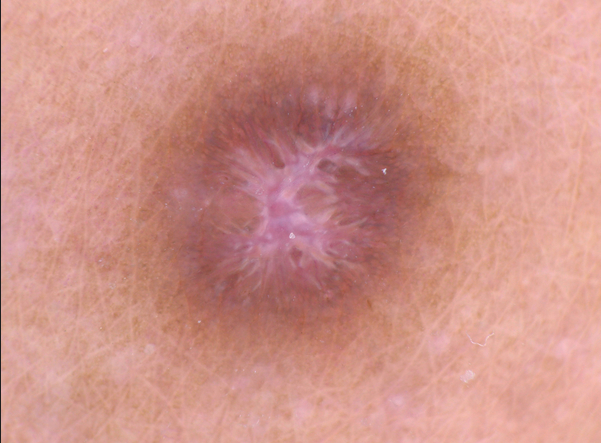

####

- **Melanoma** (mel) - These are the most serious type of skin cancer developing from melanocytes. They are usually black or brown, but they can also be skin-colored, pink, red, purple, blue, or white. Melanomas typically have irregular borders and may have different colors within the same lesion.

<center> Image of mel </center>

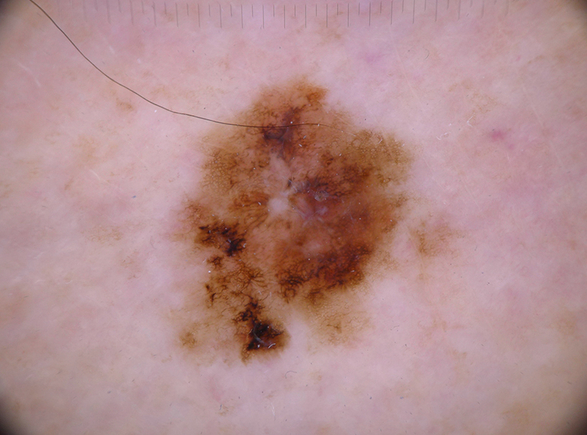

####

- **Melanocytic Nevi** (nv) - They are common benign pigmented skin lesions usually known as moles. hey are usually brownish, but can be blue, black, pink, or skin-toned. They are round or oval and have a smooth surface with a distinct edge.

<center> Image for nv </center>

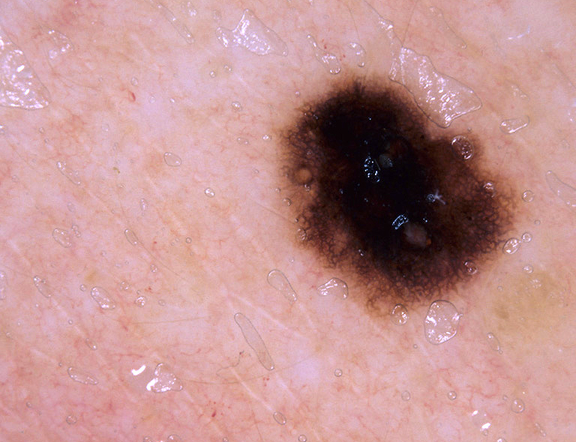

####

- **Vascular Lesions** (vasc) - There are various lesions related to the blood vessels that can vary from being benign to more serious conditions. They often appear as red, purple, or blueish spots or bumps that can vary in size and shape, and may occur anywhere on the body.

<center> Image of vasc </center>

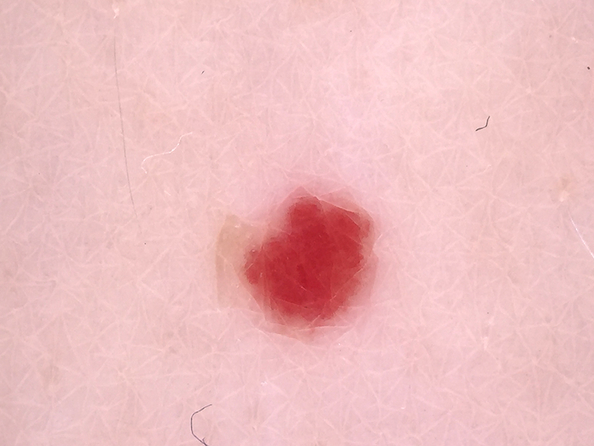

Having seen these different kinds of lesion, makes one wonder where do you even start to differentiate between these types. The images shown have already been processed and verified by professionals and are zoomed in to show the more subtle physical features. 

In real life these would all look like the same dark or red spot on your skin. 

So now we turn to Deep learning to try and create a program that will identify these images with a high enough accuracy to be useful.

# Preparing for Deep Learning

Before starting with the data processing and model building here are some things to prepare. 

## Libraries

These are the libraries used for this project. In order to replicate this work, you must have these libraries installed into your own python environment. 

*(I provided a requirements.txt for easier setup of libraries)*

In [1]:
# Python Libraries
import cv2
import itertools
import os
import random
import pandas as pd
import numpy as np
from glob import glob

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import PIL
from tqdm.notebook import tqdm, trange
from matplotlib import colormaps
from PIL import Image
from shutil import copyfile, move
from barbar import Bar

# Pytorch Libraries
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import optim
from torchvision import transforms, datasets
from torchvision.transforms import Compose
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torchvision.transforms.functional import to_pil_image
from torchvision.models import resnet50, resnet152, ResNet152_Weights, ResNet50_Weights
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchsummary import summary
from ignite.metrics import Accuracy
import tensorflow.compat.v1 as tf

# Sklearn Libraries for Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

# setting the random seed for reproducibility
random.seed(1337)
np.random.seed(1337)
torch.manual_seed(1337)
torch.cuda.manual_seed(1337)

## Functions

This is where I put the functions used throughout the notebook so that it becomes cleaner to look at. Just hide these cells after running. 

In [2]:
class EarlyStopping:
    """Early stops training if validation loss does not improve after n times.
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when monitored metric decrease."""
        if self.verbose:
            self.trace_func(f'Monitored metric has improved ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        #change this path to your path of choice
        torch.save(model.state_dict(), f'./weights/skinmodel50.pt') 
        self.val_loss_min = val_loss

In [3]:
def split_data(source, training, validation, testing, train_size, val_size): 
    """Randomnly splits the data into their desired ratios and into their
       respective folders.
       
       Args:
       
           source (string): String of path where the data will be copied from
       
           training (string): Path where the train data will be copied to
       
           validation (string): Path where the validation data will be copied to
       
           testing (string): Path where the test data will be copied to
       
           train_size (float): Size of the training set
       
           val_size (float): Size of the validation set
           
        Return:
            Files will be split into train, val, test and be copied into their
            respective directories.
    """
    
    assert train_size + val_size <= 1.0 #sum should be less than or equal 1

    files = []
    for filename in tqdm(os.listdir(source)):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    total_files = len(files)
    train_length = int(total_files * train_size)
    val_length = int(total_files * val_size)
    test_length = total_files - train_length - val_length

    shuffled_set = random.sample(files, total_files)
    
    training_set = shuffled_set[:train_length]
    validation_set = shuffled_set [train_length+1:train_length+val_length]
    test_set = shuffled_set[train_length+val_length:]

    for filename in (training_set):
        this_file = source + filename
        destination = training + filename
        copyfile(this_file, destination)

    for filename in (validation_set):
        this_file = source + filename
        destination = validation + filename
        copyfile(this_file, destination)
    
    for filename in (test_set):
        this_file = source + filename
        destination = testing + filename
        copyfile(this_file, destination)

In [4]:
def compute_img_mean_std(image_paths):
    """Normalizes the color range and computers the mean of the dataset.
    
       Args:
       
           image_paths (string): Path of the images to be used for computation
       
       Returns:
       
           means (float): Returns the mean of the image RGB values           
           stdevs (float): Returns the std of the image RGB values      
    """    
    # resizes the image to normalize the image sizes
    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3) 
    print(f"The image avg image shape {imgs.shape}")
    imgs = imgs.astype(np.float32) / 255.

    for i in tqdm(range(3)):
        pixels = imgs[:, :, i, :].ravel() 
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    #print("normalized mean = {}".format(means))
    #print("normalzied standard deviation = {}".format(stdevs))
    return means,stdevs

In [5]:
def plot_dist_bar(classes):
    """Plots a bar graph of the distributions of the samples
        
        Args:
            classes (array): Takes in the list of classes to be plotted
            
        Return:
            Bar plot of the classes    
    """
    class_names = list(classes.keys())
    class_counts = list(classes.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_counts, color='tab:red')
    plt.xlabel('Classes')
    plt.ylabel('Number of instances')
    plt.title('Class distribution')
    plt.show()

In [6]:
def plot_dist_pie(classes):
    """Plots a pie chart of the distributions of the samples
        
        Args:
            classes (array): Takes in the list of classes to be plotted
            
        Return:
            Pie chart of the classes    
    """
    class_names = list(classes.keys())
    class_counts = list(classes.values())
    # Create a colormap
    cmap = plt.get_cmap("Pastel2")

    # Create a color array using the colormap
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_names))]

    plt.figure(figsize=(10, 6))
    plt.pie(class_counts, labels=class_names, autopct='%1.1f%%',colors=colors )
    plt.title('Class distribution')
    plt.show()

In [7]:
def comp_pcc(classes):
    """Computes pcc."""
    total_instances = sum(classes.values())
    pcc = sum((n / total_instances) ** 2 for n in classes.values())
    
    #plt.figure(figsize=(10, 6))
    #plt.bar('PCC', pcc)
    #plt.ylim(0, 1)  # As PCC is a probability, its maximum value is 1
    #plt.xlabel('Metric')
    #plt.ylabel('Value')
    #plt.title('Proportional Chance Criterion (PCC)')
    #plt.show()

    return pcc

In [8]:
def plot_accuracy(train_acc, val_acc):
    """Plots the accuracy over the course of training.

    Args:
        train_acc (list): List of training accuracies for each epoch.
        val_acc (list): List of validation accuracies for each epoch.
    """
    epochs = len(train_acc)
    plt.plot(range(1, epochs + 1), train_acc, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Training')
    plt.legend()
    plt.show()

In [9]:
def plot_loss(train_loss, val_loss):
    """Plots the loss over the course of training.
    
    Args:
        train_loss (list): List of training accuracies for each epoch.
        val_loss (list): List of validation accuracies for each epoch.
    """
    #train_loss = train_loss[::-1]
    #val_loss = val_loss[::-1]
    epochs = len(train_loss)
    plt.plot(range(1, epochs + 1), train_loss, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')
    
    # Setting uniform y-ticks
    max_loss = max(max(train_loss), max(val_loss))
    min_loss = min(min(train_loss), min(val_loss))
    plt.yticks([max_loss, min_loss])
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')    
    plt.title('Loss over Training')
    plt.legend()
    plt.show()

In [10]:
def predict_single_image(image_path, model, label_mapping, device):
    """Predicts the label for a single image and displays the image 
       with predicted probabilities.

    Args:
        image_path (str): Path to the image file.
        model (torch.nn.Module): Trained model.
        label_mapping (list): List of class label mappings.
        device (torch.device): Device to perform inference on.
    
    Returns:
        predicted_label (string): Predicted label for the input sample.
        image: Image of the sample and prediction values
    """
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply transformations
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make the prediction
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(probabilities, 1)
        predicted_label = label_mapping[predicted.item()]

        # Print the image and predicted probabilities
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        ax1.imshow(image)
        ax1.set_title('Image Sample')
        ax1.axis('off')

        # Format and print the predicted probabilities
        prob_dict = {label_mapping[i]: prob.item() for i, 
                                         prob in enumerate(probabilities[0])}
        ax2.text(0.01, 0.5, "Predicted Probabilities:\n" + "\n"
           .join(f"{label}: {prob:.4f}" for label, prob in prob_dict.items()),
                 fontsize=12, verticalalignment='center')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()

        return predicted_label

In [11]:
def plot_confusion_mtx(data_loader_, label_names, model, num_passes, 
                                                                cmap='Blues'):
    """Plots a confusion matrix from the input data
        
        Args:
            data_loader_ (loader): The loader containing the data to be used
            
            label_names (list): List of labels for the matrix (in order)
            
            model: model to be evaluated
            
            num_passes (int): number of times the evaluation is looped 
            
            cmap (string): to change matplotlib cmap colors
    """
    num_classes = 7
    pred = torch.zeros(0,dtype=torch.long, device='cpu')
    label = torch.zeros(0,dtype=torch.long, device='cpu')
    pred_auc = torch.zeros(0,dtype=torch.long, device='cpu')
    
    for i in tqdm(range(num_passes)):
        with torch.no_grad():
            for k, (inputs, classes) in enumerate(data_loader_):
                model.eval()
                inputs = inputs.to(device)
                classes = classes.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
        
                # Append batch prediction results
                pred=torch.cat([pred,preds.view(-1).cpu()])
                label=torch.cat([label,classes.view(-1).cpu()])
                pred_auc = torch.cat([pred_auc,F.softmax(outputs, dim=1).cpu()])
            
    pred = pred.numpy()
    label = label.numpy()
    pred_auc = pred_auc.numpy()
    
    # Confusion matrix, classification report and AUC
    conf_mat=confusion_matrix(label, pred)    
    (ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
                                      .plot(values_format="d", cmap=cmap))
    plt.show()
    return pred, label, pred_auc

In [15]:
# Initialize the gradients and activations
# This will be used to capture model gradients and activations
gradients = None
activations = None

# Define the backward hook
def backward_hook(module, grad_input, grad_output):
    """backward hook"""
    global gradients
    gradients = grad_output


# Define the forward hook
def forward_hook(module, input, output):
    """forward hook"""
    global activations
    activations = output

def saliency_map(image_path, model):
    """Plots a Saliency map from a input image and designated model
    
        Args:
            image_path (string): Path of image to be mapped.
            model (model): Deep Learning model to be used for mapping
        Returns:
            heatmap: Heatmap of model focus during inference
            saliency map: Overlayed map of focus with sample image
    """

    # Set up model for evaluation
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()
    model.eval()
    
    # Define the image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Open, resize and normalize the image
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0).to(device)
    
    output = model(img_tensor)
    
    # Getting ground truth label from tensor array
    label = torch.tensor([1]).to(device)
    
    # Compute the loss
    loss = criterion(output, label)
    
    # Backpropagation
    loss.backward()
    
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
    
    # weight the channels by corresponding gradients
    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()
    
    # relu on top of the heatmap
    heatmap = F.relu(heatmap).to('cpu')
    
    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # Create a figure and two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot the heatmap
    ax1.matshow(heatmap.detach(), cmap='plasma')
    
    # Plot the original image
    ax2.imshow(to_pil_image(img_tensor.squeeze(), mode='RGB'))
    
    # Resize the heatmap to the same size as the input image and defines
    # a resample algorithm for increasing image resolution
    overlay = to_pil_image(heatmap.detach(), mode='F').resize((224,224)
                                                 , resample=PIL.Image.BICUBIC)
    
    # Apply any colormap you want
    cmap = colormaps['plasma']
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
    
    # Plot the heatmap on the original image, 
    # but with alpha < 1 (this defines the transparency of the heatmap)
    ax2.imshow(overlay, alpha=0.4, interpolation='nearest')
    
    # Show the plot
    plt.show()

In [16]:
def collect_summary_data(summary_path):
    
    data = {"step": [], "value": []}

    for summary in tf.train.summary_iterator(summary_path):
        for v in summary.summary.value:
            data["step"].append(summary.step)
            data["value"].append(v.simple_value)

    return data

def plot_summary(summary_path):
    # Collect data
    data = collect_summary_data(summary_path)

    # Create plot
    plt.figure(figsize=(10, 5))
    plt.plot(data["step"], data["value"], label="Your Label")
    plt.xlabel('Steps')
    plt.ylabel('Your Value')
    plt.legend(loc='upper right')
    plt.show()

In [17]:
def get_random_path(loc):
    
    
    paths = [f'./data/model/{loc}/akiec/',f'./data/model/{loc}/bcc/',
             f'./data/model/{loc}/bkl/',  f'./data/model/{loc}/df/',
             f'./data/model/{loc}/mel/',f'./data/model/{loc}/nv/',
             f'./data/model/{loc}/vasc/']
    
    sample_dir = random.choice(paths)
    test_sample = random.choice(os.listdir(sample_dir))
    image_path = sample_dir + test_sample
    
    return image_path

# Data Overview

First step is to create or acquire the dataset.

## Data Source

The dataset used in this project is called the HAM10000.
It was downloaded from `https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000` and was used for the 2018 International Skin Imaging Competition (ISIC).[4]

The dataset is downloaded as a zip file. Inside it are Folders for the dataset images, metadata csv files that contains information about the images, sample collection method, and final diagnosis. 

In [18]:
#!unzip archive.zip

## Data Loading and Preprocessing

### Exploring the Metadata

After unzipping the dataset zip file, I then took a look at the metadat csv. Looking through this first before doing any is generally the best way to get started. 

This csv file contains information on the label types, number of samples taken, some general description of where the sample was taken from, and the final diagnosis. 

In [19]:
# Reading the metadata
data = pd.read_csv('./HAM10000_metadata.csv')

In [20]:
# Taking a look at the first 3 entries of the metadata
data.head(3)

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp

From the metadata, it can be seen that it lists down the image name and its corresponding label with the columns `image_id` and `dx`

In [21]:
# Check for duplicates. Lesion id was used as basis since it is supposedly a unique ID
print(f"Initial number of rows = {len(data.duplicated(subset='lesion_id'))}")

# There were duplicates found, dropping duplicates based on id 
data = data.drop_duplicates(subset='lesion_id')

#checking number of entries left
print(f"After dropping duplicates, rows = {len(data)}")

Initial number of rows = 10015
After dropping duplicates, rows = 7470


In [22]:
# Listing out the unique labels, in this case it is from the dx columns
print(f"The unique labels are {sorted(pd.unique(data['dx']))}")

The unique labels are ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


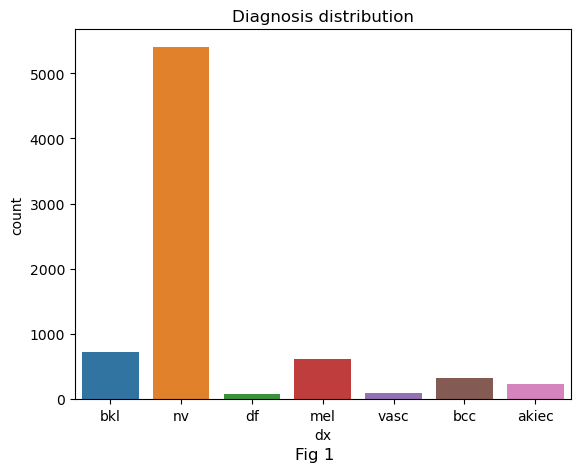

In [23]:
sns.countplot(x='dx', data=data)
plt.title('Diagnosis distribution')
plt.suptitle('Fig 1', y=0.01)
plt.show()

Now taking a look at the label distributions, `Fig 1`, it can be observed that there is an extreme degree of imbalance in the data set. The `nv` dx is has over 5000 samples in the dataset . This accounts for around 66% of the dataset while the remaining 34% is split among the remaining 6 dx. 

`dx` in this case is diagnosis

The following are some interesting plots to visualize the dataset. But keep in mind, these plots are not relevant towards the training and modeling part of this project.

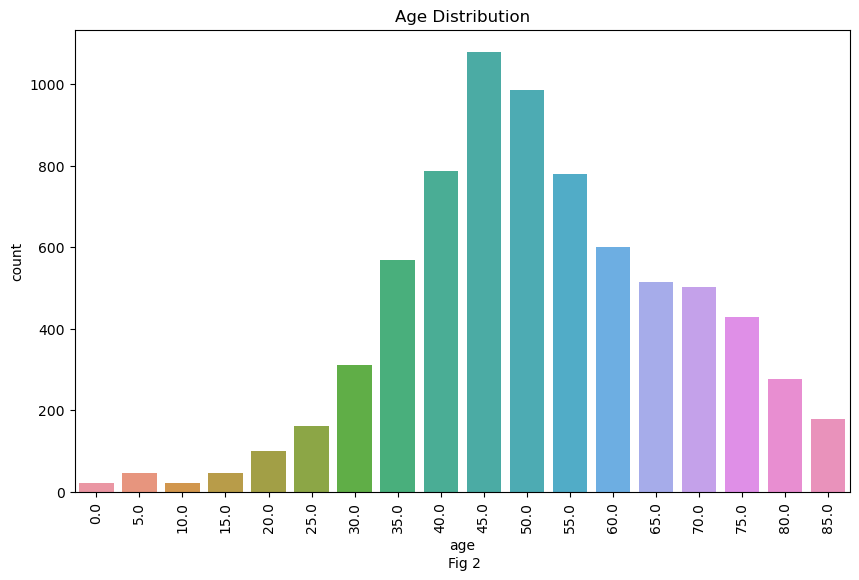

In [24]:
plt.figure(figsize=(10,6))
sns.countplot(x='age', data=data)
plt.title('Age Distribution')
plt.xticks(rotation=90)
plt.suptitle('Fig 2',x=.515, y=0.003, fontsize=10)
plt.show()

Most of these samples were taken from people in their 40s to 60s `Fig 2`

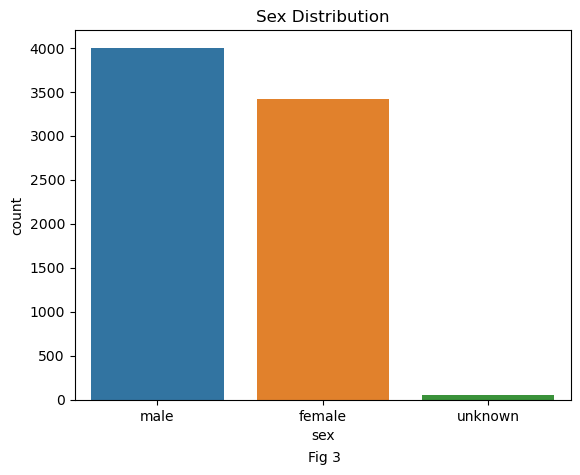

In [25]:
sns.countplot(x='sex', data=data)
plt.title('Sex Distribution')
plt.suptitle('Fig 3',x=.515, y=0.003, fontsize=10)
plt.show()

Good to see that representation is relatively balanced from both sexes. `Fig 3`

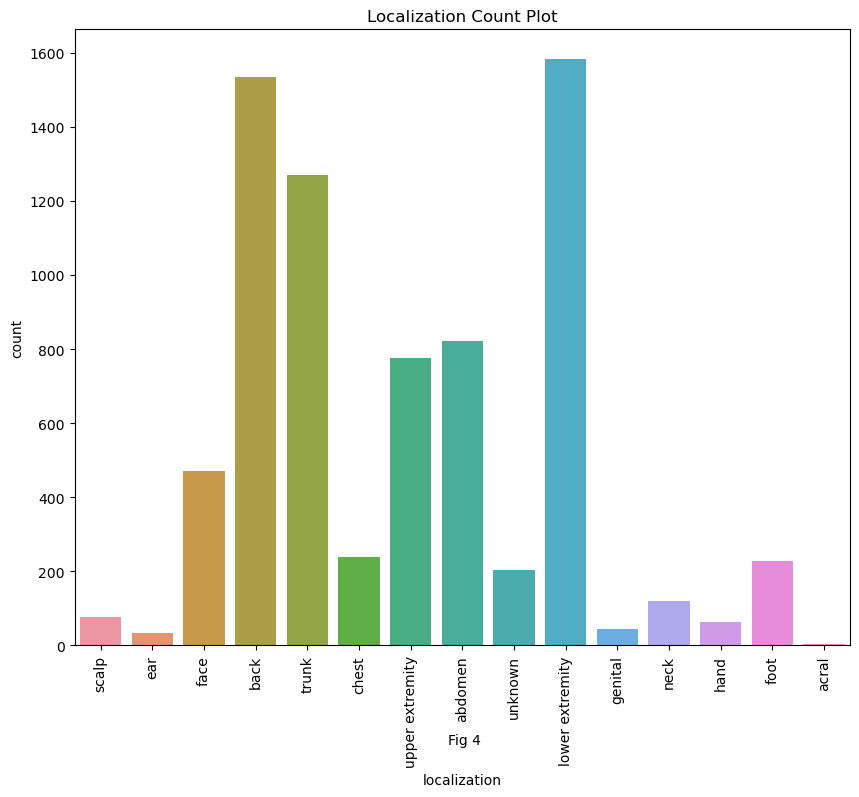

In [26]:
plt.figure(figsize=(10,8))
sns.countplot(x='localization', data=data)
plt.title('Localization Count Plot')
plt.suptitle('Fig 4',x=.515, y=0.000, fontsize=10)
plt.xticks(rotation=90)
plt.show()


`Fig 4` Shows that most of these samples come from the back, trunk, or lower extremities of the body

### Creating the File Directory

This time, we need to create the directories where we will store our image samples. These steps are ideally done inside a new folder so that there are no other folders that we don't have to worry about getting it into the wrong folders.

My apporoach for this is all the images will be first saved into one folder, then sorted after. This is a bit inefficient but it helps keep track of what goes where and is easier to troubleshoot when errors are found. 

My starting folder in this case is `HAM10000`. It is in this folder where I saved *all* images from the dataset. 
I then created subdirectories for each labels from the dataset after reading through the meta data.

In [24]:
os.mkdir('./data/source/')
os.mkdir('./data/source/mel/')
os.mkdir('./data/source/nv/')
os.mkdir('./data/source/bcc/')
os.mkdir('./data/source/akiec/')
os.mkdir('./data/source/bkl/')
os.mkdir('./data/source/df/')
os.mkdir('./data/source/vasc/')

In [27]:
src = './data/HAM10000/'
src_mel = './data/source/mel/'
src_nv = './data/source/nv/'
src_bcc = './data/source/bcc/'
src_akiec = './data/source/akiec/'
src_bkl = './data/source/bkl/'
src_df = './data/source/df/'
src_vasc = './data/source/vasc/'

In [26]:
os.mkdir('./data/model/')
os.mkdir('./data/model/training/')
os.mkdir('./data/model/training/mel/')
os.mkdir('./data/model/training/nv/')
os.mkdir('./data/model/training/bcc/')
os.mkdir('./data/model/training/akiec/')
os.mkdir('./data/model/training/bkl/')
os.mkdir('./data/model/training/df/')
os.mkdir('./data/model/training/vasc/')

os.mkdir('./data/model/validation/')
os.mkdir('./data/model/validation/mel/')
os.mkdir('./data/model/validation/nv/')
os.mkdir('./data/model/validation/bcc/')
os.mkdir('./data/model/validation/akiec/')
os.mkdir('./data/model/validation/bkl/')
os.mkdir('./data/model/validation/df/')
os.mkdir('./data/model/validation/vasc/')

os.mkdir('./data/model/test/')
os.mkdir('./data/model/test/mel/')
os.mkdir('./data/model/test/nv/')
os.mkdir('./data/model/test/bcc/')
os.mkdir('./data/model/test/akiec/')
os.mkdir('./data/model/test/bkl/')
os.mkdir('./data/model/test/df/')
os.mkdir('./data/model/test/vasc/')

In [28]:
train_mel = './data/model/training/mel/'
train_nv = './data/model/training/nv/'
train_bcc = './data/model/training/bcc/'
train_akiec = './data/model/training/akiec/'
train_bkl = './data/model/training/bkl/'
train_df = './data/model/training/df/'
train_vasc = './data/model/training/vasc/'

val_mel = './data/model/validation/mel/'
val_nv = './data/model/validation/nv/'
val_bcc = './data/model/validation/bcc/'
val_akiec = './data/model/validation/akiec/'
val_bkl = './data/model/validation/bkl/'
val_df = './data/model/validation/df/'
val_vasc = './data/model/validation/vasc/'

test_mel = './data/model/test/mel/'
test_nv = './data/model/test/nv/'
test_bcc = './data/model/test/bcc/'
test_akiec = './data/model/test/akiec/'
test_bkl = './data/model/test/bkl/'
test_df = './data/model/test/df/'
test_vasc = './data/model/test/vasc/' 

The output folders should look like something like this

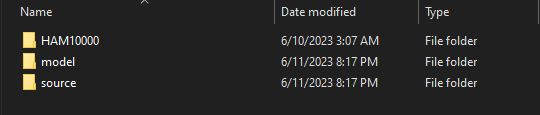

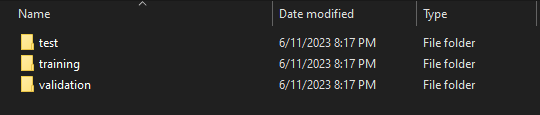

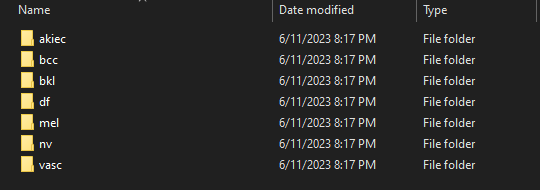

### Moving Images to their own Class Folders

After creating those directories and folders, these next series of cells will transfer the compiled images from the folder `HAM10000` to their respective label folders and this will also split them into the Train, Val, Test sets.

As seen with the metadata file earlier, it contains the image names and their respective labels. We will use these information to segregate and categorize out images.

In [101]:
# Sort images based on the csv metadata of image names and diagnosis
image_names = [x for x in data['image_id']]
diagnosis = [x for x in data['dx']]

for index, image in tqdm(enumerate(image_names)):
    
    image = image + '.jpg'
    
    if diagnosis[index] == 'mel':
        copyfile(os.path.join(src, image), os.path.join(src_mel, image))
        
    elif diagnosis[index] == 'nv':
        copyfile(os.path.join(src, image), os.path.join(src_nv, image))
        
    elif diagnosis[index] == 'bcc': 
        copyfile(os.path.join(src, image), os.path.join(src_bcc, image))
        
    elif diagnosis[index] == 'akiec': 
        copyfile(os.path.join(src, image), os.path.join(src_akiec, image))
        
    elif diagnosis[index] == 'bkl':
        copyfile(os.path.join(src, image), os.path.join(src_bkl, image))
        
    elif diagnosis[index] == 'df':  
        copyfile(os.path.join(src, image), os.path.join(src_df, image))
        
    elif diagnosis[index] == 'vasc':
        copyfile(os.path.join(src, image), os.path.join(src_vasc, image))      

0it [00:00, ?it/s]

Next, I counted the number of samples based on the files found inside the folders. It everything went correctly, the number of files should be equal to the number of rows found in the metadata earlier. 

In [29]:
# Print amount of pictures for each class
n_samples=  len(data)  
n_classes= len(pd.unique(data['dx']))
n_mel= len(os.listdir(src_mel))
n_nv= len(os.listdir(src_nv))
n_bcc= len(os.listdir(src_bcc))
n_akiec= len(os.listdir(src_akiec))
n_bkl= len(os.listdir(src_bkl))
n_df = len(os.listdir(src_df))
n_vasc = len(os.listdir(src_vasc))

print(f"akiec: {n_akiec}, bcc :{n_bcc}, bkl:{n_bkl}, df:{n_df}"\
                 f", mel:{n_mel}, nv:{n_nv}, vasc:{n_vasc}, total:{n_samples}")

akiec: 228, bcc :327, bkl:727, df:73, mel:614, nv:5403, vasc:98, total:7470


The total number of samples aligns with the metadata number. So we're doing good so far.
Next is to split the data into their own train/val/test sets using the function `split_data`

The split I went with is not ideal, but for the purpose of this model training this is what I found to have the highest scores.

In [102]:
# Split all the labels into Train, Val, Test sets
# What ever is remaining from 1-train+val is the test size in this case .1
train_size = 0.7 
val_size = 0.2
    
split_data(src_mel,   train_mel,   val_mel,   test_mel,   train_size, val_size)
split_data(src_nv,    train_nv,    val_nv,    test_nv,    train_size, val_size)
split_data(src_bcc,   train_bcc,   val_bcc,   test_bcc,   train_size, val_size)
split_data(src_akiec, train_akiec, val_akiec, test_akiec, train_size, val_size)
split_data(src_bkl,   train_bkl,   val_bkl,   test_bkl,   train_size, val_size)
split_data(src_df,    train_df,    val_df,    test_df,    train_size, val_size)
split_data(src_vasc,  train_vasc,  val_vasc,  test_vasc,  train_size, val_size)

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/5403 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

In [30]:
# Print amount of pictures for each class after split, train/val.
print(f"akiec train={len(os.listdir(train_akiec))},"\
      f" val={len(os.listdir(val_akiec))},"\
      f" and test={len(os.listdir(test_akiec))}")
print()
print(f"bcc train={len(os.listdir(train_bcc))},"\
      f" val={len(os.listdir(val_bcc))},"\
      f" and test={len(os.listdir(test_bcc))}")
print()
print(f"bkl train={len(os.listdir(train_bkl))},"\
      f" val={len(os.listdir(val_bkl))},"\
      f" and test={len(os.listdir(test_bkl))}")
print()
print(f"df train={len(os.listdir(train_df))},"\
      f" val={len(os.listdir(val_df))},"\
      f" and test={len(os.listdir(test_df))}")
print()
print(f"mel train={len(os.listdir(train_mel))},"\
      f" val={len(os.listdir(val_mel))},"\
      f" and test={len(os.listdir(test_mel))}")
print()
print(f"nv train={len(os.listdir(train_nv))},"\
      f" val={len(os.listdir(val_nv))},"\
      f" and test={len(os.listdir(test_nv))}")
print()
print(f"vasc train={len(os.listdir(train_vasc))},"\
      f" val={len(os.listdir(val_vasc))},"\
      f" and test={len(os.listdir(test_vasc))}")

akiec train=159, val=44, and test=24

bcc train=228, val=64, and test=34

bkl train=508, val=144, and test=74

df train=51, val=13, and test=8

mel train=429, val=121, and test=63

nv train=3782, val=1079, and test=541

vasc train=68, val=18, and test=11


Next we compute the means and stdevs of the images to be used as basis for image transformations

In [100]:
# compute the data mean and standard devation
img_dir = './data/source'
all_image_path = glob(os.path.join(img_dir , '*', '*.jpg'))
norm_mean,norm_std = compute_img_mean_std(all_image_path)


print(f"The normalized mean of image sizes are {norm_mean},"\
      f" and the normalize standard deviation is {norm_std}")

  0%|          | 0/7470 [00:00<?, ?it/s]

The image avg image shape (224, 224, 3, 7470)


  0%|          | 0/3 [00:00<?, ?it/s]

The normalized mean of image sizes are [0.78101206, 0.5371426, 0.55846536], and the normalize standard deviation is [0.1354707, 0.15066084, 0.1665726]


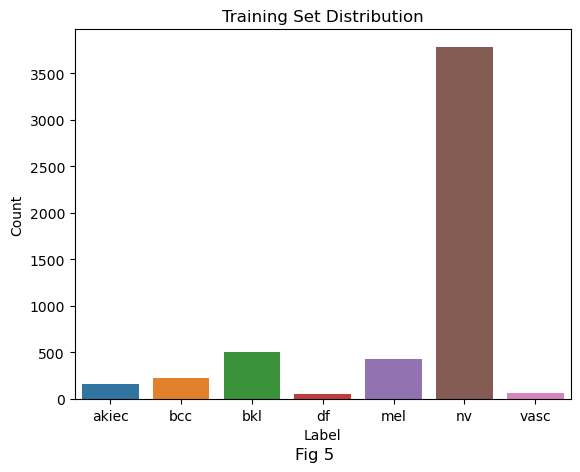

In [31]:
# Plotting distribution again, but this time only from the train set
classes = {'akiec':len(os.listdir(train_akiec)),
            'bcc':len(os.listdir(train_bcc)),
            'bkl':len(os.listdir(train_bkl)), 
            'df': len(os.listdir(train_df)), 
            'mel':len(os.listdir(train_mel)), 
            'nv':len(os.listdir(train_nv)), 
            'vasc': len(os.listdir(train_vasc))}
class_df = pd.DataFrame(list(classes.items()), columns=['Label', 'Count'])
sns.barplot(x='Label', y='Count', data=class_df)
plt.title('Training Set Distribution')
plt.suptitle('Fig 5', y=0.01)
plt.show()

As seen again from the training set distribution, we have to address the class imbalance present in the dataset.[5] 

To do this, I will use the crossEntropy loss' weights parameter. 
First thing to do is to compute the weights of the classes and then convert it into a tensor which can then be used by the model later during training

In [32]:
# The data set is very imbalanced, compute weights to be used to mitigate data imbalance in training
n_samples_per_class = [n_akiec, n_bcc, n_bkl, n_df, n_mel, n_nv, n_vasc]
class_weights = [n_samples / (n_classes * n_samples_per_class[i]) for i in range(n_classes)]
class_weights_tensor = torch.Tensor(class_weights)
print(f"Weights of the classes {class_weights}")

Weights of the classes [4.680451127819549, 3.2634338138925294, 1.467871880526626, 14.61839530332681, 1.7380176826430898, 0.197509320218926, 10.889212827988338]


As shown, the weights are there to compensate for the low and high count classes. 
The higher the sample count, the lower the weight and vice versa.

I did not use compute the weights using only the training set since the dataset and training set distributions are the same. 

In [33]:
# Computing the Proportional Chance Criterion
pcc = comp_pcc(classes)
print(f"PCC: {pcc:.4f}, PCC to beat {(pcc*1.25):.4f}")

PCC: 0.5432, PCC to beat 0.6790


The PCC acts as a target for our model to beat. The PCC represents the chances of predicting a label right purely from a probabilistic standpoint. 

Setting a target to beat of 0.6786, which is 1.25 x PCC, would mean that the model is statistically better than randomly guessing the predictions.

### Image Transformation and Tensor Conversion


Now that the images are where we want them to be. Organized and segregated. It is time to convert them to a from that a deep learning model can understand and use.

In [34]:
# Setting the directory path of the image sets
traindir = './data/model/training/'
valdir = './data/model/validation/'
testdir = './data/model/test/'

On this next part, we apply transformations and augmentations to our images. Then convert them to tensors.

*Tensors are a form of data that is similar to matrices that represent our images. This is the format used by deep learning models in the pytorch library.*

For the training set, we introduced some perturbations to the images by using the random flips and rotations. This allows the images to be more "noisy" so that the model learns to generalize better. Then resizing them to so it fits the model's inputs.

For the Validation and Test set, we only resized and converted them to tensors.

These arrangement of transformations is used because it is the standard application for this pre-trained model as indicated by the pytorch documentations.[6]

In [35]:
# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-180, 180))], p=0.99),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [36]:
# Load images and apply transformations
train_dataset = ImageFolder(traindir, transform=train_transforms)
val_dataset = ImageFolder(valdir, transform=val_transforms)
test_dataset = ImageFolder(testdir, transform=test_transforms)

In [37]:
# Load images from ImageFolder and apply batching algorithms
# These parameters are used to better work in my GPU, feel free to change them
train_loader = DataLoader( train_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

val_loader = DataLoader( val_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

test_loader = DataLoader( test_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

In [38]:
print(val_dataset.class_to_idx)
print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


After doing all these steps, the images are now loaded and ready to be processed by the model for training and evalution. 

# The ResNet50 Model

I used this model because it is one of the more popular state-of-the-art pre-trained models available in pytorch. It is a powerful model based on the ResNet architecture that is specially designed for image classification tasks.[7]

Though there are many more models and iterations that can be done for this project or if you are feeling adventurous, you can design your own, using the pre-trained model saves on time and is easier to impelement.[8] 

I found this model sufficient for this project as you will see later on.

Someother notable models to try are:

- VGG
- Inception
- Efficientnet

## Defining the Model

To start with the model training, first we define the model

In [39]:
# Send computations to GPU if available
# This is just a nice code to have in any case
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

To define the model, we start with selecting the model, in this case ResNet50.
Then I modified the model to fit this project's needs, I changed the final fc layer to (2048,7) to output seven labels. These correspond with our data labels.[9]

crossEntropyLoss is used as the loss function because this is specifically used for classification tasks and the Adam optimizer is used for the optimizer function because is an excellent all around optimizer. 

In [48]:
# Initializing the Model
model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
#model = resnet152(weights='IMAGENET1K_V2').to(device)
#model = resnet50(weights='IMAGENET1K_V2').to(device)

# Changing the final layer to output 7 labels since our dataset has 7
model.fc = nn.Linear(2048, 7).to(device)

# Define the criterion used for training
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

# Define the optimizer used for training
#optimizer = optim.Adam(model.parameters(), weight_decay=0.0001)
optimizer = optim.AdamW(model.parameters())

# Acts as a data log to see metrics over the course of the training
writer = SummaryWriter(log_dir='./content', filename_suffix="skin50")

In [115]:
# Brief summary of the model architecture and its layers
#summary(model, input_size=(3, 224, 224))

## Training the Model


Training the model is now straightforward. 

In a high level explanation, it goes something like this:

The model contains some weights which are values that are changed and trained based on the training data fed to it.

Then for each epoch, 
- the model gets a batch of data from the dataloader

- the model performs a forward pass, produces an initial output from the batch of data

- evaluate the output of the foward pass with the loss function

- then the optimizer changes the some values within the model that will adjust the output to be close to the input

then repeat.


This process goes on until the loss and accuracy are at a satisfactory level. If it doesn't reach that level, change some parameters like the learning rates, change the loss function, change the train/test split and redo the training. 

In [49]:
# Sets the early stopping point, if the Loss function plateaus, the model stops training and saves the last set of weights. 
#early_stopping = EarlyStopping(patience=50, verbose=True)

# Saves the accuracy over the course of the training
train_accuracy_list = []
val_accuracy_list = []

# Saves the loss values over the course of the training
val_loss_list = []
train_loss_list = []

In [86]:
# Epochs dictate the number of times a model goes through a training loop. 
epochs = 1 # Higher is usually better.

In [87]:
# Complete Train/Val loop
for epoch in trange(epochs):
    
    train_loss = 0.00
    val_loss = 0.00
    
    train_eval_accuracy = Accuracy()
    val_eval_accuracy = Accuracy()

    
    print(f'Epoch {epoch+1}')

    # Training loop
    for idx, (inputs, labels) in enumerate(Bar(train_loader)):
        model.train()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.item()
        train_eval_accuracy.update((nn.functional.softmax(outputs, dim=1)
                                                                    , labels))
      
    train_acc = train_eval_accuracy.compute()
    train_accuracy_list.append(train_acc) 
    print(f"Train Accuracy: {train_acc}")
    train_loss /= len(train_loader)
    train_loss_formated = "{:.4f}".format(train_loss)
    train_loss_list.append(train_loss_formated)

    # Validation loop
    with torch.no_grad():
        for inputs, labels in val_loader:
            model.eval()           
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_eval_accuracy.update((nn.functional.softmax(outputs, dim=1)
                                                                    , labels))
            
    val_acc = val_eval_accuracy.compute()
    val_accuracy_list.append(val_acc)
    print(f"Val Accuracy: {val_acc}")
    val_loss /= len(val_loader)
    val_loss_formated = "{:.4f}".format(val_loss)
    val_loss_list.append(val_loss_formated)
    print(f'Training Loss: {train_loss_formated}')
    print(f"Validation Loss: {val_loss_formated}")

    # TensorBoard writer 
    writer.add_scalar('Loss/train', train_loss, epoch+1)
    writer.add_scalar('Loss/val', val_loss, epoch+1)
    writer.add_scalar('Accuracy/train', train_acc, epoch+1)
    writer.add_scalar('Accuracy/val', val_acc, epoch+1)
    
    #Turn on if you want to continuously save model states during training
    ## Early Stopping
    #early_stopping(val_loss, model)       
    #if early_stopping.early_stop:
    #    print("Early stopping")
    #    break

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1
  64/5225: [>...............................] - ETA 0.0s

C:\Users\Kaizen\anaconda3\envs\ml3\Lib\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


5225/5225: [===============================>] - ETA 0.6ss
Train Accuracy: 0.9908133971291866
Val Accuracy: 0.8435603506405934
Training Loss: 0.0114
Validation Loss: 2.3466


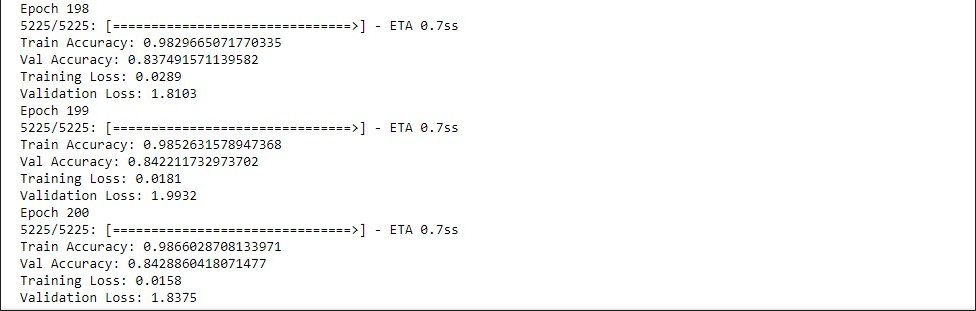

<center> output after 200 epochs training </center>

In [ ]:
# Saves the whole model, space intensive
#torch.save(model, './model_final.pth')

In [ ]:
# Saves the model state as a dictionary, more compact
#torch.save(model.state_dict(), f'./model_final_dict.pt')#

In [ ]:
# Use this to load the last checkpoint with the state dictionary
#model.load_state_dict(torch.load('./_.pt')) 

In [51]:
# Use this to load a previously trained model.
#model = torch.load('./model1.pth')

In [ ]:
# Check the loaded model if you want.
#summary(model)

# Model Evaluation

On the next part, we will be taking a look at how well the model we trained performs. 

## Results

The collected accuracy and loss values over the course of the training epochs will be save into a dataframe and exported as a csv file for possible future use.

In [106]:
# Run this to load from a previous training session
#results_df = pd.read_csv('./training_results_6.csv', index_col=0) 

In [98]:
# Run this block if you have just finished training a new model
#results_df = pd.DataFrame()
#results_df['train_loss'] = train_loss_list
#results_df['val_loss'] = val_loss_list
#results_df['train_acc'] = train_accuracy_list
#results_df['val_acc'] = val_accuracy_list

In [99]:
# Export accuracy and loss data to csv
#results_df.to_csv('./training_results_61.csv')

In [107]:
results_df.head(3)

train_loss  val_loss  train_acc   val_acc
0      0.6932    0.6723   0.759083  0.784221
1      0.5507    0.6286   0.805793  0.771409
2      0.5063    0.6353   0.817512  0.784895

## Loss and Accuracy Plots

Now we get to plot the Loss and Accuracy values during the duration of the model training. 

Expected behavior is that Loss values should be gradually decreasing. Indicating that the predicted outputs are getting closer towards the ground-truth. But in this case, diverging loss values indicate overfitting from the model.

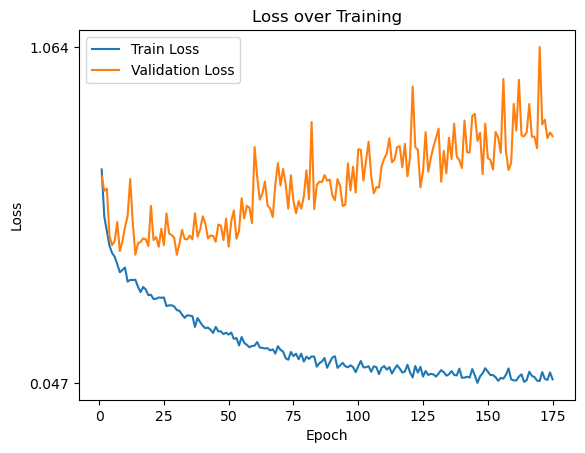

Min loss during training 0.0473
Min loss during validation 0.4349


In [108]:
plot_loss(results_df['train_loss'],results_df['val_loss'])
print(f"Min loss during training {(results_df['train_loss'].min())}")
print(f"Min loss during validation {(results_df['val_loss'].min())}")

And in contrast, The accuracy values go up as with more epochs done. At 150 epochs we have reached 99% Training accuracy, and 85% Validation accuracy. 

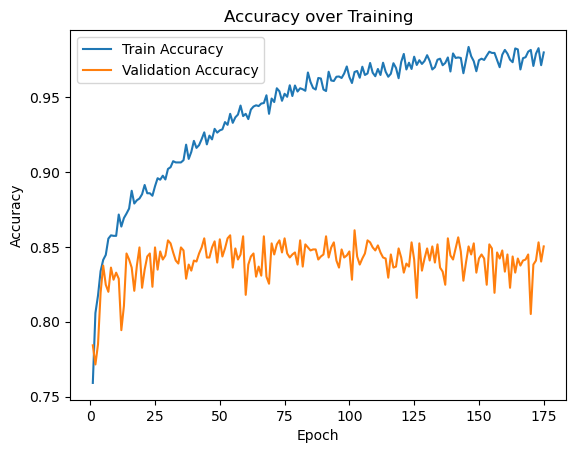

Max accuracy during training 98.3593%
Max accuracy during validation 86.1092%


In [109]:
# After the training loop
plot_accuracy(results_df['train_acc'],results_df['val_acc'])
print(f"Max accuracy during training {(results_df['train_acc'].max())*100:.4f}%")
print(f"Max accuracy during validation {(results_df['val_acc'].max())*100:.4f}%")

## Confusion Matrix

The confusion matrix is one of the best ways to evaluate a classifier model like what we have.
It creates a plot that compares predicted labels vs true labels. 

For this particular confusion matrix, the ideal output would be where the boxes along the diagonal contain the highest numbers. As this is the number where the predicted label is equal to the ground truth label. 

  0%|          | 0/5 [00:00<?, ?it/s]

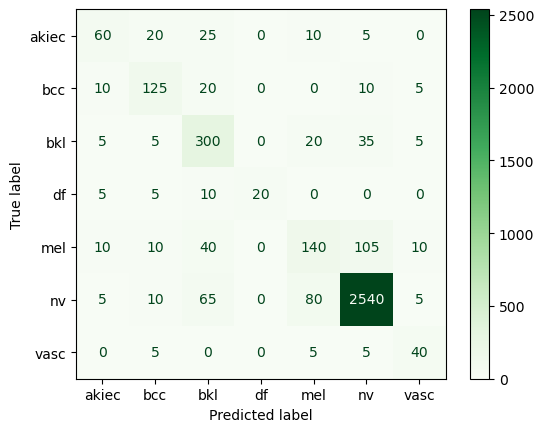

In [91]:
label_names = ['akiec','bcc','bkl','df','mel','nv','vasc',]
pred, label, pred_auc = plot_confusion_mtx(test_loader, label_names,
                                                      model, 5, cmap='Greens')

Some more important things to see with these plots and values are the recall, precision, and f1 scores. 

Precision Scores indicate how well your model has predicted the correct labels out of all the labels IT has predicted.
In contrast, Recall Scores indicate how well a model has predicted the correct labels out of all correct labels in the dataset.

And as for the F1 Score it acts as function of both precision and recall. In general, a model with a higher F1 score is the better model overall. 

For this specific classifier, we want a high recall score. This is because we are dealing with predicting individuals with possible health risks and getting false positives does not carry as big of a risk as getting a false negative. Although, the precision score should also be of satisfactory value since too many false positives would lead to people not trusting the model anymore. 

In [92]:
label_ohe = nn.functional.one_hot(torch.tensor([label]), num_classes=7)
every_auc = roc_auc_score(label_ohe.view([pred_auc.shape[0], 
               pred_auc.shape[1]]), pred_auc, multi_class='ovr', average=None)

print(classification_report(label, pred, target_names=label_names))

              precision    recall  f1-score   support

       akiec       0.63      0.50      0.56       120
         bcc       0.69      0.74      0.71       170
         bkl       0.65      0.81      0.72       370
          df       1.00      0.50      0.67        40
         mel       0.55      0.44      0.49       315
          nv       0.94      0.94      0.94      2705
        vasc       0.62      0.73      0.67        55

    accuracy                           0.85      3775
   macro avg       0.73      0.67      0.68      3775
weighted avg       0.85      0.85      0.85      3775



And lastly, the AUC scores. This indicates how well the model can distinguish between the labels.
For example, for akiec class, it has a AUC score of 0.9681. This indicates that it can diffirentiate the akiec label from all the other labels 96% of the time. 

In [93]:
for i, every in enumerate(label_names):
    print(f'AUC of class {every} = {every_auc[i]}')

AUC of class akiec = 0.956452348381213
AUC of class bcc = 0.9854776862201192
AUC of class bkl = 0.9597968012064928
AUC of class df = 0.9871151271753681
AUC of class mel = 0.918272318561336
AUC of class nv = 0.9646077703111233
AUC of class vasc = 0.9628543499511241


This time we reload the validation/test set but with added augmentations to add randomness to the data using `RandomHorizontalFlip` and `RandomApply`.

In [94]:
var_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-180, 180))], p=0.99),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

var_dataset = datasets.ImageFolder(
    valdir, transform=var_transforms)

var_loader = torch.utils.data.DataLoader(
    var_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

  0%|          | 0/5 [00:00<?, ?it/s]

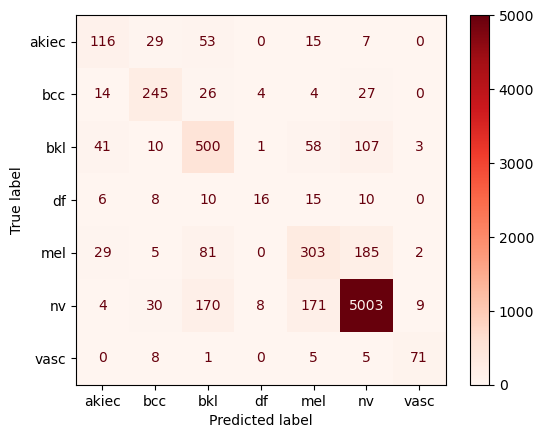

In [95]:
label_names = ['akiec','bcc','bkl','df','mel','nv','vasc',]
pred, label, pred_auc = plot_confusion_mtx(var_loader, label_names, model, 5, 
                                                                  cmap='Reds')

In [96]:
label_ohe = nn.functional.one_hot(torch.tensor([label]), num_classes=7)
every_auc = roc_auc_score(label_ohe.view([pred_auc.shape[0], 
               pred_auc.shape[1]]), pred_auc, multi_class='ovr', average=None)

print(classification_report(label, pred, target_names=label_names))

              precision    recall  f1-score   support

       akiec       0.55      0.53      0.54       220
         bcc       0.73      0.77      0.75       320
         bkl       0.59      0.69      0.64       720
          df       0.55      0.25      0.34        65
         mel       0.53      0.50      0.52       605
          nv       0.94      0.93      0.93      5395
        vasc       0.84      0.79      0.81        90

    accuracy                           0.84      7415
   macro avg       0.68      0.64      0.65      7415
weighted avg       0.85      0.84      0.84      7415



In [97]:
for i, every in enumerate(label_names):
    print(f'AUC of class {every} = {every_auc[i]}')

AUC of class akiec = 0.9703212458146441
AUC of class bcc = 0.9895221106412966
AUC of class bkl = 0.9367533814621194
AUC of class df = 0.9420533751962324
AUC of class mel = 0.9230713219499763
AUC of class nv = 0.960618146615403
AUC of class vasc = 0.9925051194539249


And we can see that even with the random augementations applied, we still get similar and consistent scores across the board. 

This is good because it shows that we can expect similar performance for the model outside of the training/validation dataset.

### Model 0 Performance Summary

This is the result of one of my earlier runs, as you can see, this pipeline has the potential to return excellent results.
The model pipeline used on this was:
- ResNet50 on default weights,
- Dataset was split 80/20 for train/val
- crossEntropyLoss() function. There was no imbalance compensation for this model
- Adam optimizer with weigth_decay=.0001

The performance was evaluated by sampling the validation sets 5 times, with each run applying random transformations to the input batches. 

But since this does not have a proper test set and has no class imbalance compensation method, I proceeded to experiment with more parameter tuning. 

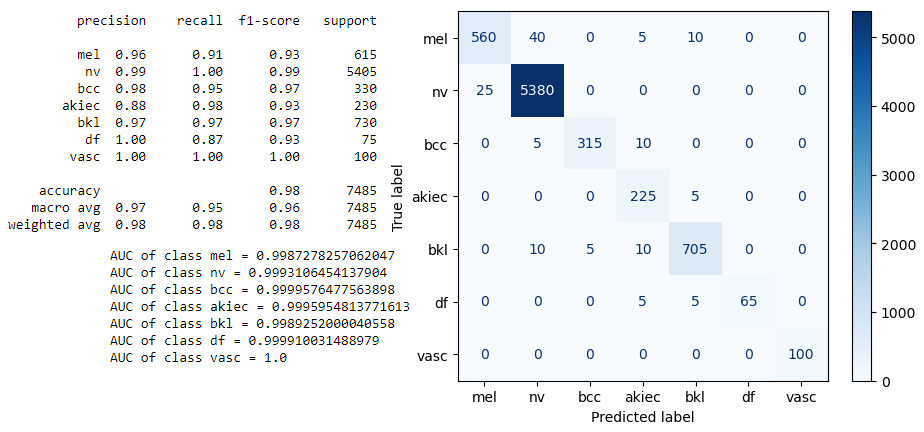

## Single Image Inference

Finally! Putting it all together, we have a running pipeline that takes an image from your file path and generates a prediction from it complete with all probabilities and a saliency map.

Important things to look at here are:

- The probabilties of the prediction. Let's say the model predicted 55% chance for nv but 45% chance for bcc. Ideally, you do not trust the prediction seek professional opinion about that particular lesions since bcc is a very serious condition. 


- The Heatmap and Saliency map. These plots illustrate how the model sees the image and what parts it focuses on. These activations are from low to high indicated by the colors purple to yellow, with yellow meaning that the part is of high activation or focus.[10]

In [69]:
# Register the hooks on the last convolutional layer for mapping image activations
# We need these for the salient maps to get information from activations
backward_hook_handle = model.layer4[-1].register_backward_hook(backward_hook)
forward_hook_handle = model.layer4[-1].register_forward_hook(forward_hook)

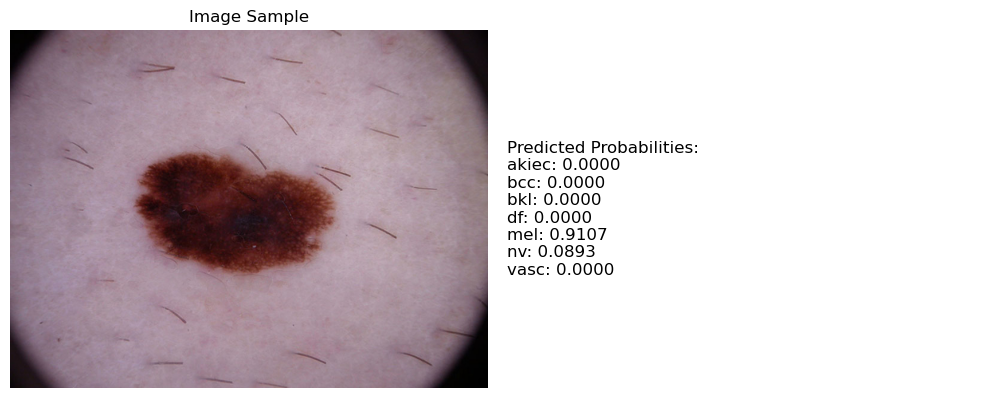

C:\Users\Kaizen\anaconda3\envs\ml3\Lib\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


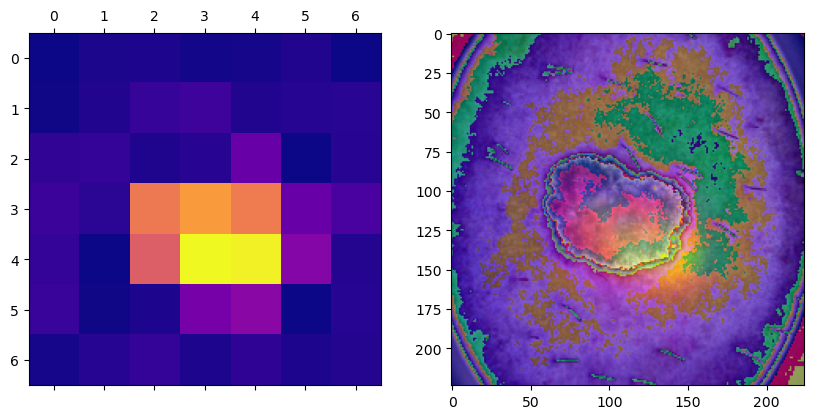

Predicted Label: mel
./data/model/validation/mel/ISIC_0034118.jpg


In [70]:
# Get a random image from a folder from the file directory(train, validation, test)
image_path = get_random_path('validation')
label_mapping = test_dataset.classes

predicted_label = predict_single_image(image_path, model, label_mapping
                                                                     , device)
saliency_map(image_path, model)
print(f"Predicted Label: {predicted_label}")
print(f"{image_path}")

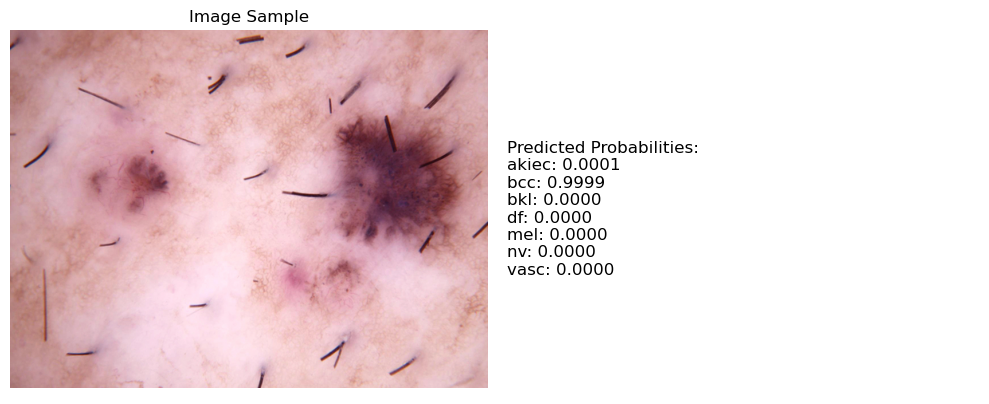

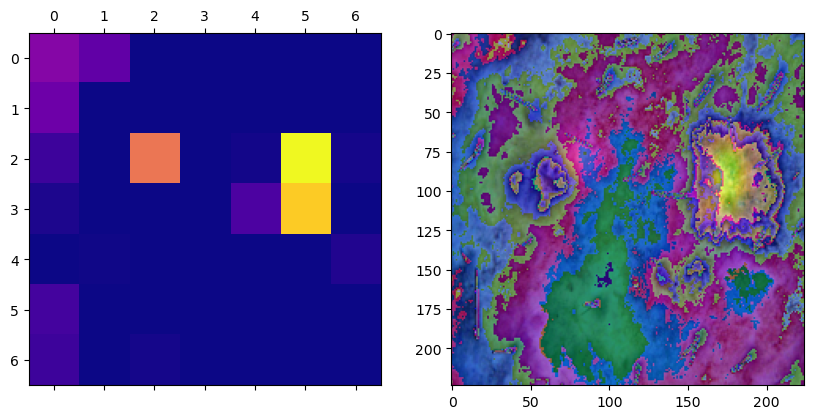

Predicted Label: bcc
./data/model/validation/bcc/ISIC_0029123.jpg


In [105]:
image_path = get_random_path('validation')
label_mapping = test_dataset.classes

predicted_label = predict_single_image(image_path, model, label_mapping, device)
saliency_map(image_path, model)
print(f"Predicted Label: {predicted_label}")
print(f"{image_path}")

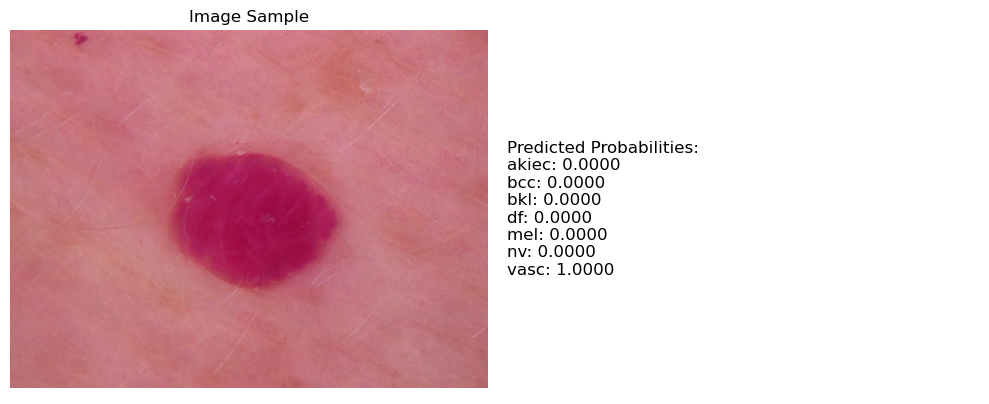

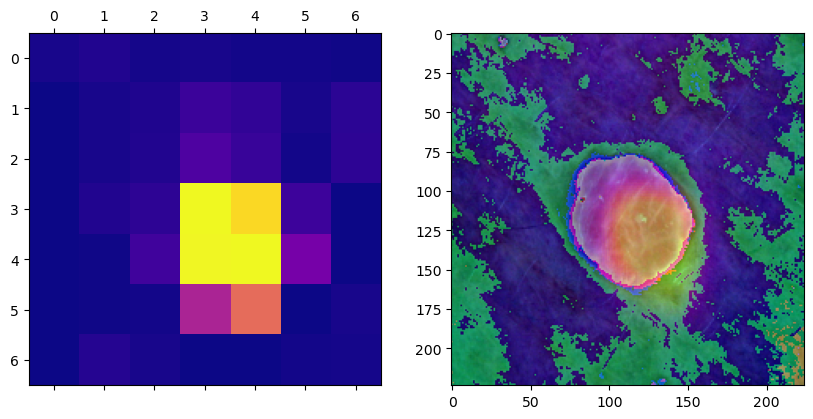

Predicted Label: vasc
./data/model/validation/vasc/ISIC_0029742.jpg


In [75]:
image_path = get_random_path('validation')
label_mapping = test_dataset.classes

predicted_label = predict_single_image(image_path, model, label_mapping, device)
saliency_map(image_path, model)
print(f"Predicted Label: {predicted_label}")
print(f"{image_path}")

Cool, right? 

But before you go on and upload your own picture into this to be evaluated, do not expect good results.
Keep in mind, these images from the dataset were curated by professionals and was collected and framed using professional equipment.

The model would need more specialized preprocessing in order to properly evaluate smartphone pictures because of a lot of factors. 

Factors like:

- Camera Resolution 
- Camera Sensor
- Condition of the environment
- Lighting

and various other factors that need to be addressed and be taken into account before feeding it into the model. 

# Results and Discussions

The final model have shown some great results. 

With the different iterations of the model returning around **85% - 95%** accuracies. This is much higher than the target to beat which was **67%** set by the pcc. 

Over the course of this project, I trained two models. 

`Model0` = This model was using the default ResNet50 weights, the dataset was only split between Train/Val at 80-20, and the imbalance dataset was not addressed with any methods. 

`Model1` = This model was also using the default ResNet50 weights. But this time, the dataset was split between Train/Val/Test at 70-20-10, and the imbalance dataset was addressed by using the crossEntropyLoss functions weight parameter.

During the training process it was observed that Model0 was returning excellent results. It had 95% accuracy after 150 epochs of training and had 94-99% f1 scores on the different classes. In contrast, Model1 was also showing great results but the validation accuracy plateaud at 85% after 250 epochs. Even though Model1 had the class imbalance method in place it still performed worse than Model1. 

This can possibly be attributed to the fact that splitting the data 3 ways, was giving the model too few of samples to learn from. This can be addressed by getting more data in a future attempt. 

As for the F1 Score, Model0 again returns excellent results with 90++ scores across all the labels. While Model1 with all the corrections and tuning was mediocre in performance. Even with high accuracy results, the F1 scores from the minor labels were barely beating PCC. This would entail more tuning work. But that will be for another time. 

Training on these models takes my computer approximately 1min and 30s per epoch on ResNet50. And due to time constraints I am unable to run training loops hours on end. It should also be noted that Model1 training was already plateauing at 150 epochs returning 99% accuracy on train but only 85% on validation. 

For my thoughts, though Model0 was performing better, it might not be able to replicate that success in unseen data because it might have overfitting issues as compared to Model1. 

But this could also just be proof of the robustness of the ResNet architecture when it comes to learning from imbalanced dataset. 

# Conclusion

We have demonstrated in this project on how it is possible to create an accurate skin lesion classifier.

The model just requires some tweaking to get it robust enough for a more real-world like testing, but the real test would be introducing actual, unseen, real-world data to it.

On the other hand, the idea of further developing this into an application for a smartphone would require more work, more tuning, and more data.

There is a lot of iterations involved in tuning and making these models. For me personally, tuning the weights, playing with the optimizers and pre-trained model weights took a lot of time but was also very fun. There is a lot of trial and error involved in this process.

Though it should be noted that these trials are based on knowledge from reading the proper practices and library documentations of pytorch and the like. 

# Future Work and Final Thoughts

The hope is that projects like this are turned into useable applications in the real-world, making health related diagnostics and screening more accessbile. 

Even if the application is not 100% perfect, just the fact that it's easy to use, and is more frequently is enough for people to get more curious and concerned about their own health. 

Just being told the possibility of having a serious illness is sometimes enough to get them to go checked earlier and improve the chances of the resulting treatment. 

# Links

Here's the GitHub link to more files related to this project and the appendix. https://github.com/kaiserdx/ml3_individual_project.git

and a gdrive to some of the models I have trained. https://drive.google.com/drive/folders/1b-mNbPe139aeTQGIagzvYcpS-LVVnB8z?usp=drive_link

# References

[1] Sandberg, S. (2018, September 24). How AI is Reshaping Mobile Landscape? YourStory.com. https://yourstory.com/mystory/how-ai-is-reshaping-mobile-landscape-8jk3r2konh

[2] C. (n.d.). Skin Lesions: What They Are, Types, Causes & Treatment. Cleveland Clinic. https://my.clevelandclinic.org/health/diseases/24296-skin-lesions

[3] College of Pathologists, T. R. (n.d.). Histopathology. Histopathology. https://www.rcpath.org/discover-pathology/news/fact-sheets/histopathology.html

[4] ISIC Challenge. (n.d.). ISIC Challenge. https://challenge.isic-archive.com/landing/2018/

[5] Dealing with imbalanced datasets in pytorch. (2018, August 7). PyTorch Forums. https://discuss.pytorch.org/t/dealing-with-imbalanced-datasets-in-pytorch/22596

[6] resnet50 &mdash; Torchvision 0.15 documentation. (n.d.). Resnet50 &Mdash; Torchvision 0.15 Documentation. https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights

[7] Danielsen, N. (2019, November 26). Simple Image Classification with ResNet 50. Medium. https://medium.com/@nina95dan/simple-image-classification-with-resnet-50-334366e7311a

[8] Huilgol, P. (2020, August 17). Top 4 Pre-Trained Models for Image Classification with Python Code. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

[9] How to modify the final FC layer based on the torch.model. (2018, July 15). PyTorch Forums. https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/21

[10] Khalid, I. A. (2021, January 4). Saliency Map for Visualizing Deep Learning Model Using PyTorch. Medium. https://towardsdatascience.com/saliency-map-using-pytorch-68270fe45e80

[11] N. (n.d.). GitHub - NikitaBezukhov/Skin-neoplasm-classifier-ResNet50. GitHub. https://github.com/NikitaBezukhov/Skin-neoplasm-classifier-ResNet50

[12] ChatGPT